In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer
from utils_add_features import *
from utils_pipeline import *
from utils_evaluate import *
from collections import Counter
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
import os

In [2]:
BASE_DIR = os.getcwd()

# look in the data folder and take the feature you want to reduced.
FEATURES_TO_ANALYSE = "shape_firstorder_glcm_features"
# Shape + texture features 
DATA_DIR = os.path.join(BASE_DIR,"data",FEATURES_TO_ANALYSE)

TRAIN_DIR = os.path.join(DATA_DIR,"TrainningDataset_reduced.csv")
LABEL_DIR = os.path.join(DATA_DIR,"TrainningDatasetCategory.csv")
TEST_DIR = os.path.join(DATA_DIR,"TestingDataset_reduced.csv")


In [3]:
# X contain basic features, volumes and border of each segmentation as well as weight and age of each person.
X = pd.read_csv("TrainningInput_Dataset_myseg_area.csv",index_col = 0)
print(f"Original Feature from segmentation and MetaData :\n {X.columns.to_list()}\n\n")

y = pd.read_csv("TrainningOutput_Dataset_myseg_area.csv",index_col=0)

# Creation of new features
X = clean_features(X)
print(f"New Features :\n {X.columns.to_list()}")

# Same thing with the testing dataset :
X_test = pd.read_csv("TestingInput_Dataset_myseg_area.csv",index_col=0)
X_test = clean_features(X_test)

# Shuffle the data
X = X.sample(n=X.shape[0])
y = y.loc[X.index]


Original Feature from segmentation and MetaData :
 ['ED_LV_shape_LeastAxisLength', 'ED_MY_shape_Maximum2DDiameterSlice', 'ED_MY_shape_MeshVolume', 'ED_MY_shape_SurfaceVolumeRatio', 'ES_RV_shape_Maximum2DDiameterRow', 'ES_MY_shape_Sphericity', 'ES_MY_shape_SurfaceVolumeRatio', 'ED_RV_shape_MeshVolume_over_ED_LV_shape_MeshVolume', 'ED_RV_shape_MeshVolume_over_ED_MY_shape_MeshVolume', 'ED_RV_shape_MeshVolume_over_ES_RV_shape_MeshVolume', 'ED_RV_shape_MeshVolume_over_ES_LV_shape_MeshVolume', 'ED_LV_shape_MeshVolume_over_ES_RV_shape_MeshVolume', 'ED_LV_shape_MeshVolume_over_ES_LV_shape_MeshVolume', 'ED_MY_shape_MeshVolume_over_ES_RV_shape_MeshVolume', 'ED_MY_shape_MeshVolume_over_ES_LV_shape_MeshVolume']




In [5]:
# 0) compute current counts and desired targets (+20% each)
counter = Counter(y["Category"])  
target_counts = {cls: int(n * 1.5) for cls, n in counter.items()}
print(counter,target_counts)

Counter({4: 20, 0: 20, 3: 20, 1: 20, 2: 20}) {4: 30, 0: 30, 3: 30, 1: 30, 2: 30}


In [ ]:
import itertools, math
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Data frames
# ------------------------------------------------------------------
df_plot = X.copy()
df_plot["Category"] = y["Category"]

features  = X.columns                # every feature you want to plot
pairs     = list(itertools.combinations(features, 2))
n_pairs   = len(pairs)

# ---- layout: choose how many columns in the grid
n_cols    = 3                         # 3 per row → adjust as you like
n_rows    = math.ceil(n_pairs / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(4*n_cols, 4*n_rows),
                         sharex=False, sharey=False)
axes      = axes.flatten()           # easy iteration

# ------------------------------------------------------------------
# Scatter each pair
# ------------------------------------------------------------------
for ax, (f1, f2) in zip(axes, pairs):
    for cat, sub in df_plot.groupby("Category"):
        ax.scatter(sub[f1], sub[f2], label=cat, s=25, alpha=0.7)
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title(f"{f1} vs {f2}")

# first subplot carries the legend
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, title="Category")

# delete any empty axes (if n_pairs is not a multiple of n_cols)
for ax in axes[len(pairs):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [6]:
# Creation de la pipeline
pipeline = ImbPipeline([ 
    ("normaliser" , StandardScaler()),                  
    ("dataAugment", BorderlineSMOTE(
        sampling_strategy=target_counts,  
        kind='borderline-1')),
    ("classifier", RandomForestClassifier()),
])
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'normaliser', 'dataAugment', 'classifier', 'normaliser__copy', 'normaliser__with_mean', 'normaliser__with_std', 'dataAugment__k_neighbors', 'dataAugment__kind', 'dataAugment__m_neighbors', 'dataAugment__random_state', 'dataAugment__sampling_strategy', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__max_samples', 'classifier__min_impurity_decrease', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__monotonic_cst', 'classifier__n_estimators', 'classifier__n_jobs', 'classifier__oob_score', 'classifier__random_state', 'classifier__verbose', 'classifier__warm_start'])

In [4]:
pipeline = ImbPipeline([ 
    ("dataAugment", GaussianNoiseInjector()),
    ("normaliser" , MinMaxScaler()),                  
    ("classifier", RandomForestClassifier()),
])
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'dataAugment', 'normaliser', 'classifier', 'dataAugment__noise_factor', 'normaliser__clip', 'normaliser__copy', 'normaliser__feature_range', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__max_samples', 'classifier__min_impurity_decrease', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__monotonic_cst', 'classifier__n_estimators', 'classifier__n_jobs', 'classifier__oob_score', 'classifier__random_state', 'classifier__verbose', 'classifier__warm_start'])

In [5]:
# Cross Validation
# Seed of randomness to be able to compare different model more accuratly
cv = StratifiedKFold(shuffle=True)

In [7]:
param_grid = {
    'classifier__n_estimators': [100,150,500],
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth': [5,None],
    'classifier__min_samples_leaf': [1,2,3,4],
    "dataAugment__noise_factor" : [0,0.05]
    #"dataAugment__k_neighbors": [3, 5],
    #"dataAugment__m_neighbors": [7, 10]
    
}

In [25]:

search_spaces = {
    # clé = "étape__paramètre"  (nom__param dans un Pipeline)
    "classifier__n_estimators"    : Integer(100, 200),
    "classifier__max_depth"       : [None],
    "classifier__min_samples_leaf": Integer(1,3),
    "classifier__max_features"    : ["sqrt"],
    "dataAugment__noise_factor" : [0.05],
    "dataAugment__k_neighbors": Integer(3, 5),
    # "dataAugment__m_neighbors": Integer(7, 10),
 
}

In [26]:
grid_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_spaces,
    n_iter=40,              
    cv=cv,
    scoring=make_scorer(accuracy_score),
    n_jobs=-1,              
    verbose=3,
    return_train_score=True,
)
grid_search.fit(X,y["Category"])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=164, dataAugment__noise_factor=0.05;, score=(train=0.988, test=0.950) total time=   0.8s
[CV 4/5] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=164, dataAugment__noise_factor=0.05;, score=(train=1.000, test=0.950) total time=   0.9s
[CV 1/5] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=164, dataAugment__noise_factor=0.05;, score=(train=0.988, test=0.950) total time=   1.0s
[CV 3/5] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=164, dataAugment__noise_factor=0.05;, score=(train=1.000, test=0.950) total time=   0.8s
[CV 5/5] END classifier__max_depth=None, classifier__max_features=sqr

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
              estimator=Pipeline(steps=[('dataAugment',
                                         GaussianNoiseInjector()),
                                        ('normaliser', MinMaxScaler()),
                                        ('classifier',
                                         RandomForestClassifier())]),
              n_iter=40, n_jobs=-1, return_train_score=True,
              scoring=make_scorer(accuracy_score, response_method='predict'),
              search_spaces={'classifier__max_depth': [None],
                             'classifier__max_features': ['sqrt'],
                             'classifier__min_samples_leaf': Integer(low=1, high=3, prior='uniform', transform='normalize'),
                             'classifier__n_estimators': Integer(low=100, high=200, prior='uniform', transform='normalize'),
                             'dataAugment__noise_factor': [0.05]},
              verbose=3)

In [8]:
grid_search = GridSearchCV(pipeline,param_grid=param_grid,cv=cv,verbose=3,return_train_score=True)
grid_search.fit(X,y["Category"])

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=100, dataAugment__noise_factor=0;, score=(train=0.988, test=0.900) total time=   0.1s
[CV 2/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=100, dataAugment__noise_factor=0;, score=(train=1.000, test=0.900) total time=   0.0s
[CV 3/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=100, dataAugment__noise_factor=0;, score=(train=1.000, test=0.800) total time=   0.0s
[CV 4/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=100, dataAugment__noise_factor=0;, score=(train=1.000, test=0.950) total time=   0.0s
[CV 5/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_sampl

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('dataAugment', GaussianNoiseInjector()),
                                       ('normaliser', MinMaxScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [5, None],
                         'classifier__max_features': ['sqrt'],
                         'classifier__min_samples_leaf': [1, 2, 3, 4],
                         'classifier__n_estimators': [100, 150, 500],
                         'dataAugment__noise_factor': [0, 0.05]},
             return_train_score=True, verbose=3)

The model is fitted and now we want to properly evaluate the results. 
We select only the result from the best_params founded by the search. (Reminder that the best params are the one that provided the best mean validation score)

In [9]:
# set of parameters that gave the best cv result
best_params = grid_search.best_params_
print(f"best parameters : {best_params} ")

# Detailed result of the cross validation for each set of parameters
results = grid_search.cv_results_

# CV result for the best paramaters.

# GOAL : 
# The closest to 1 the mean score is on the val set the better
# The smallest the std on the val set the better.
best_idx = results['params'].index(best_params)
mean_train_score = results['mean_train_score'][best_idx]
mean_valid_score = results['mean_test_score'][best_idx]
std_train_score = results['std_train_score'][best_idx]
std_valid_score = results['std_test_score'][best_idx]
print(f"score validation set : {mean_valid_score,std_valid_score}")
print(f"score trainning set : {mean_train_score,std_train_score}")

best parameters : {'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 100, 'dataAugment__noise_factor': 0.05} 
score validation set : (np.float64(0.9400000000000001), np.float64(0.037416573867739396))
score trainning set : (np.float64(0.9775), np.float64(0.009354143466934868))


In [10]:
# CONSTRUCTION DE LA PIPELINE D"INFERENCE

best_pipeline = grid_search.best_estimator_
inference_steps = [
    (name, step)
    for name, step in best_pipeline.steps
    if name != "dataAugment" # on ne bruite plus les données 
]
inf_pipeline = Pipeline(inference_steps)
print(inf_pipeline.get_params())

{'memory': None, 'steps': [('normaliser', MinMaxScaler()), ('classifier', RandomForestClassifier(max_depth=5, min_samples_leaf=3))], 'transform_input': None, 'verbose': False, 'normaliser': MinMaxScaler(), 'classifier': RandomForestClassifier(max_depth=5, min_samples_leaf=3), 'normaliser__clip': False, 'normaliser__copy': True, 'normaliser__feature_range': (0, 1), 'classifier__bootstrap': True, 'classifier__ccp_alpha': 0.0, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': None, 'classifier__max_samples': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__monotonic_cst': None, 'classifier__n_estimators': 100, 'classifier__n_jobs': None, 'classifier__oob_score': False, 'classifier__random_state': None, 'classifier__verbose': 0, 'classifier__warm_start': 

In [11]:
f_importance = grid_search.best_estimator_.named_steps["classifier"].feature_importances_
f_name = grid_search.best_estimator_.named_steps["normaliser"].get_feature_names_out()
feature_importance = pd.DataFrame({
    "feature": f_name,
    "importance": f_importance
})
feature_importance.sort_values("importance", ascending=False, inplace=True)
print(feature_importance)

                                              feature  importance
10  ED_RV_shape_MeshVolume_over_ES_LV_shape_MeshVo...    0.104875
12  ED_LV_shape_MeshVolume_over_ES_LV_shape_MeshVo...    0.099041
7   ED_RV_shape_MeshVolume_over_ED_LV_shape_MeshVo...    0.098629
13  ED_MY_shape_MeshVolume_over_ES_RV_shape_MeshVo...    0.086812
14  ED_MY_shape_MeshVolume_over_ES_LV_shape_MeshVo...    0.078577
8   ED_RV_shape_MeshVolume_over_ED_MY_shape_MeshVo...    0.074329
11  ED_LV_shape_MeshVolume_over_ES_RV_shape_MeshVo...    0.068677
0                         ED_LV_shape_LeastAxisLength    0.066480
3                      ED_MY_shape_SurfaceVolumeRatio    0.059989
6                      ES_MY_shape_SurfaceVolumeRatio    0.059054
5                              ES_MY_shape_Sphericity    0.056072
4                    ES_RV_shape_Maximum2DDiameterRow    0.048268
9   ED_RV_shape_MeshVolume_over_ES_RV_shape_MeshVo...    0.045368
1                  ED_MY_shape_Maximum2DDiameterSlice    0.028781
2         

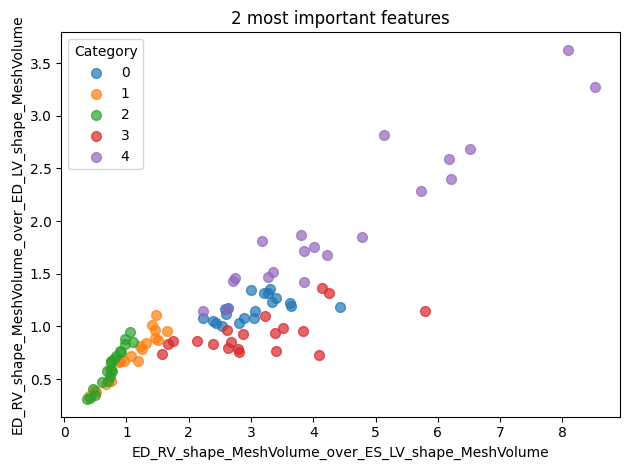

In [12]:
import matplotlib.pyplot as plt


df = X.copy()
df['Category'] = y["Category"]

fig, ax = plt.subplots()
for cat, sub in df.groupby('Category'):
    F = feature_importance[:3]["feature"].to_list()
    F1,F2 = F[0],F[2]
    ax.scatter(sub[F1], sub[F2], label=cat, s=50, alpha=0.7)
ax.set_xlabel(F1)
ax.set_ylabel(F2)
ax.set_title('2 most important features')
ax.legend(title='Category')
plt.tight_layout()
plt.show()

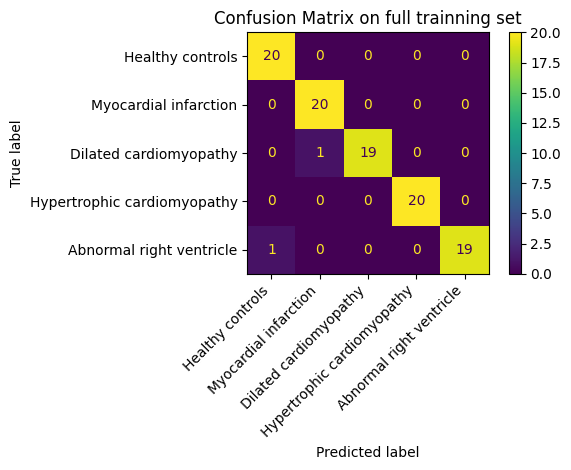

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.95      1.00      0.98        20
           2       1.00      0.95      0.97        20
           3       1.00      1.00      1.00        20
           4       1.00      0.95      0.97        20

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



In [13]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import ConfusionMatrixDisplay

class_names = {0 : "Healthy controls",
                1: "Myocardial infarction",
                2: "Dilated cardiomyopathy",
                3: "Hypertrophic cardiomyopathy",
                4 : "Abnormal right ventricle"
}
labels = sorted(class_names.keys())
y_pred = inf_pipeline.predict(X)

disp = ConfusionMatrixDisplay.from_predictions(
    y["Category"], y_pred,
    display_labels=[class_names[i] for i in labels],     
)
disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), rotation=45, ha='right')
disp.ax_.set_title("Confusion Matrix on full trainning set")
plt.tight_layout()
plt.show()

print(classification_report(y["Category"],y_pred))

In [17]:
# Get the probabilities to get better insight on the model performance

proba = inf_pipeline.predict_proba(X)
print(f"average entropy score : {np.mean(certainty_score(proba))}")
print(f"\naverage margin score : {np.mean(margin_score(proba))}\n")
# Below 
treshold = 0.4
L = [0,0,0,0,0]
for x in proba : 
    a= 0
    index = []
    for ind,i in enumerate(x) :
        if i > treshold : 
            a+=1
            index.append(ind)
    if a >=2 : 
        for j in index : 
            L[j] +=1  
#print(proba)  
print(L)

average entropy score : 0.7257725698429353

average margin score : 0.7421374837662339

[0, 2, 2, 0, 0]


In [18]:
# Predict on the test set
import os

submission_name = "submission_15_from_all_features_reduced__simple_pipeline.csv"
submission_dataframe = pd.DataFrame(columns=["Id","Category"])
submission_dataframe["Id"] = X_test.index 

y_test_pred = inf_pipeline.predict(X_test)
submission_dataframe["Category"] = y_test_pred
submission_dataframe.to_csv(os.path.join(os.getcwd(),submission_name),index=False)

print("File saved")

File saved


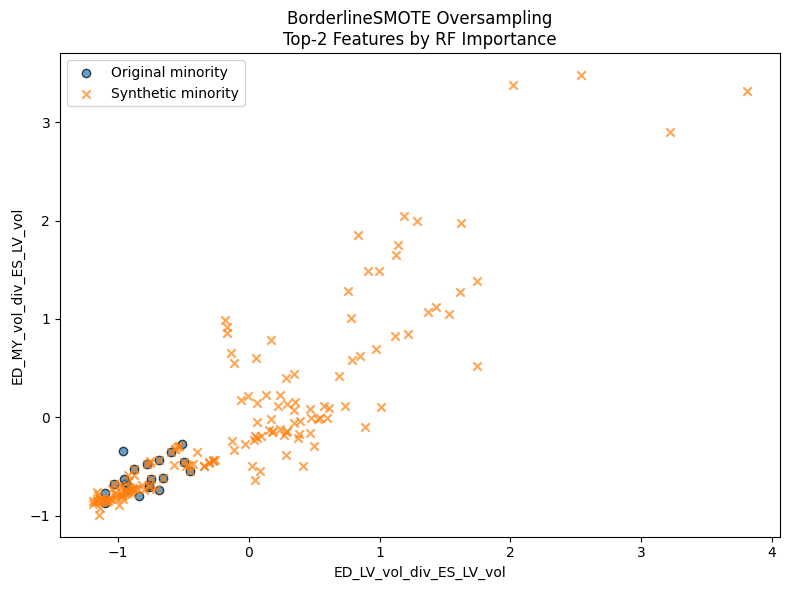

In [16]:
visualize_oversampling(grid_search, X, y["Category"])

Below two cells to save the results : the model and the description of the method used.

In [16]:
description = "Gaussian Noise + MinmaxScaler + Randomforest with GridSearch. all features execpt : ES_LV_vol_div_ES_MY_vol." 
other_params = "4 high entropy between classe 1 and 2"
name_folder = "RF"
feature_used = f_name
informationDict = {
    "description": description,
    "model parameters" : best_params,
    "features used" : feature_used,
    "mean test accuracy with best params" : mean_valid_score ,
    "std  test with best params" : std_valid_score,
    "mean train accuracy with best params" : mean_train_score,
    "std train best params" : std_train_score,
    "other parms" : other_params,
    
}

In [48]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

mask = y['Category'].isin([1, 2])
X_binary = X.loc[mask]
y_binary = y.loc[mask]


le = LabelEncoder()
y_binary = le.fit_transform(y_binary)

pipeline_binary_rf = Pipeline([
    ("dataAugment",GaussianNoiseInjector()),
    ("norm",MinMaxScaler()),
    ("classifier",RandomForestClassifier()),
])

pipeline_binary_svc = Pipeline([
    ("dataAugment",GaussianNoiseInjector()),
    ("norm",StandardScaler()),
    ("svc",SVC(probability=True)),
])

param_grid_binary_svc = {
    'dataAugment__noise_factor' : [0.05],
    'svc__C':       [5,7,10,15,20,50],
    'svc__kernel':  ['rbf'],
    'svc__gamma':   [0.01,0.1,0.05],
}

search_spaces = {
    # taux d'apprentissage (log-uniform entre 0.01 et 0.1)
    'xgb__learning_rate':    (0.01, 0.1, 'log-uniform'),
    # régularisation L1 (log-uniform entre 1e-8 et 1.0)
    'xgb__reg_alpha':        (1e-8, 1.0, 'log-uniform'),
    # régularisation L2 (log-uniform entre 1e-3 et 10.0)
    'xgb__reg_lambda':       (1e-3, 10.0, 'log-uniform'),
    # méthode de sélection de features (seulement cyclic ou shuffle)
    'xgb__feature_selector': ['cyclic', 'shuffle'],
    # nombre d'estimateurs (entier uniforme entre 50 et 500)
    'xgb__n_estimators':     (50, 500),
}


param_grid_binary_rf = {
    'dataAugment__noise_factor' : [0.05,0.0,0.1],
    'classifier__n_estimators': [50,100,300],
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth': [3,5],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf': [1,2],
}

param_grid_binary_xgb = {
    'xgb__n_estimators':    [100, 200],
    'xgb__max_depth':       [6,None,5],
    'xgb__learning_rate':   [0.01, 0.1, 0.2],
    'xgb__gamma':           [0, 1, 5],
    'xgb__reg_alpha':       [0, 0.1, 1],
    'xgb__reg_lambda':      [0.1,1, 5, 10]
}
pipeline_binary_xgb = Pipeline([
    ("dataAugment",GaussianNoiseInjector(0.0)),
    ("norm",StandardScaler()),
    ("xgb",XGBClassifier(booster = "gblinear",    objective='binary:logistic',)),
])

grid_search_binary = BayesSearchCV(
    estimator=pipeline_binary_xgb,
    search_spaces=search_spaces,
    n_iter=35,              
    cv=3,
    scoring=make_scorer(accuracy_score),
    n_jobs=-1,              
    verbose=3,
    return_train_score=True,
)

# grid_search_binary = GridSearchCV(pipeline_binary_xgb,param_grid=param_grid_binary_xgb,cv=5,verbose=3,return_train_score=True)
grid_search_binary.fit(X_binary,y_binary)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3] END xgb__feature_selector=shuffle, xgb__learning_rate=0.02771453051236487, xgb__n_estimators=211, xgb__reg_alpha=1.6916930477275103e-08, xgb__reg_lambda=0.004495233080996873;, score=(train=1.000, test=0.929) total time=   0.1s
[CV 3/3] END xgb__feature_selector=shuffle, xgb__learning_rate=0.02771453051236487, xgb__n_estimators=211, xgb__reg_alpha=1.6916930477275103e-08, xgb__reg_lambda=0.004495233080996873;, score=(train=1.000, test=0.769) total time=   0.1s
[CV 2/3] END xgb__feature_selector=shuffle, xgb__learning_rate=0.02771453051236487, xgb__n_estimators=211, xgb__reg_alpha=1.6916930477275103e-08, xgb__reg_lambda=0.004495233080996873;, score=(train=1.000, test=0.692) total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END xgb__feature_selector=shuffle, xgb__learning_rate=0.01448389099882808, xgb__n_estimators=233, xgb__reg_alpha=0.04590467942913322, xgb__reg_lambda=0.02357419291203257;, score=(train=1.000, test=0.846) total time=   0.1s
[

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('dataAugment',
                                         GaussianNoiseInjector(noise_factor=0.0)),
                                        ('norm', StandardScaler()),
                                        ('xgb',
                                         XGBClassifier(base_score=None,
                                                       booster='gblinear',
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feat...
                                                       num_parallel_tree=None, ...))]),
              n_iter=35, n_jobs=-1, return_train_score=True,
              scoring=make_scorer(accuracy_score, response_method='predict'),
              search_spaces={'xgb__feature_selector': ['cyclic', 'shuffle'],
                             'xgb__learning_rate': (0.01, 0.1, 'log-uniform'),
                             'xgb__n_estimators': (50, 500),
                             'xgb__reg_alpha': (1e-08, 1.0, 'log-uniform'),
                             'xgb__reg_lambda': (0.001, 10.0, 'log-uniform')},
              verbose=3)

In [49]:
# set of parameters that gave the best cv result
best_params_binary = grid_search_binary.best_params_
print(f"best parameters : {best_params_binary} ")

# Detailed result of the cross validation for each set of parameters
results_binary = grid_search_binary.cv_results_

# CV result for the best paramaters.

# GOAL : 
# The closest to 1 the mean score is on the val set the better
# The smallest the std on the val set the better.
best_idx_binary = results_binary['params'].index(best_params_binary)
mean_train_score_binary = results_binary['mean_train_score'][best_idx_binary]
mean_valid_score_binary = results_binary['mean_test_score'][best_idx_binary]
std_train_score_binary = results_binary['std_train_score'][best_idx_binary]
std_valid_score_binary = results_binary['std_test_score'][best_idx_binary]
print(f"score validation set : {mean_valid_score_binary,std_valid_score_binary}")
print(f"score trainning set : {mean_train_score_binary,std_train_score_binary}")

best parameters : OrderedDict({'xgb__feature_selector': 'shuffle', 'xgb__learning_rate': 0.05459298228645974, 'xgb__n_estimators': 437, 'xgb__reg_alpha': 1.4115368075235438e-07, 'xgb__reg_lambda': 0.05542659948954834}) 
score validation set : (np.float64(0.8461538461538461), np.float64(0.10878565864408422))
score trainning set : (np.float64(0.9491927825261158), np.float64(0.048101391309132296))


In [50]:
# CONSTRUCTION DE LA PIPELINE D"INFERENCE

best_pipeline_binary = grid_search_binary.best_estimator_
inference_steps_binary = [
    (name, step)
    for name, step in best_pipeline_binary.steps
    if name != "dataAugment" # on ne bruite plus les données 
]
inf_pipeline_binary = Pipeline(inference_steps_binary)
print(inf_pipeline_binary.get_params())

{'memory': None, 'steps': [('norm', StandardScaler()), ('xgb', XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              feature_selector='shuffle', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05459298228645974, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=437, n_jobs=None, ...))], 'transform_input': None, 'verbose': False, 'norm': StandardScaler(), 'xgb': XGBClassifier(base_score=None, booster='gblinear', callback

In [51]:
f_importance_binary = grid_search_binary.best_estimator_.named_steps["xgb"].feature_importances_
f_name_binary = grid_search_binary.best_estimator_.named_steps["norm"].get_feature_names_out()
feature_importance_binary = pd.DataFrame({
    "feature": f_name_binary,
    "importance": f_importance_binary
})
feature_importance_binary.sort_values("importance", ascending=False, inplace=True)
print(feature_importance_binary)

                    feature  importance
1                 ED_LV_vol    1.006170
22  ES_RV_vol_div_ED_RV_vol    0.926546
4                 ES_LV_vol    0.823347
32  ES_MY_vol_div_ED_RV_vol    0.514319
26  ES_RV_vol_div_ES_MY_vol    0.485434
28  ES_LV_vol_div_ED_LV_vol    0.447340
6              body_surface    0.406058
24  ES_RV_vol_div_ED_MY_vol    0.405405
17  ED_MY_vol_div_ED_RV_vol    0.387355
31  ES_LV_vol_div_ES_MY_vol    0.363466
12  ED_LV_vol_div_ED_RV_vol    0.347575
29  ES_LV_vol_div_ED_MY_vol    0.328862
5                 ES_MY_vol    0.325983
2                 ED_MY_vol    0.320149
27  ES_LV_vol_div_ED_RV_vol    0.221280
3                 ES_RV_vol    0.218273
23  ES_RV_vol_div_ED_LV_vol    0.174056
16  ED_LV_vol_div_ES_MY_vol    0.140438
13  ED_LV_vol_div_ED_MY_vol    0.135943
34  ES_MY_vol_div_ED_MY_vol    0.105242
21  ED_MY_vol_div_ES_MY_vol   -0.028832
11  ED_RV_vol_div_ES_MY_vol   -0.048347
35  ES_MY_vol_div_ES_RV_vol   -0.150342
25  ES_RV_vol_div_ES_LV_vol   -0.170720


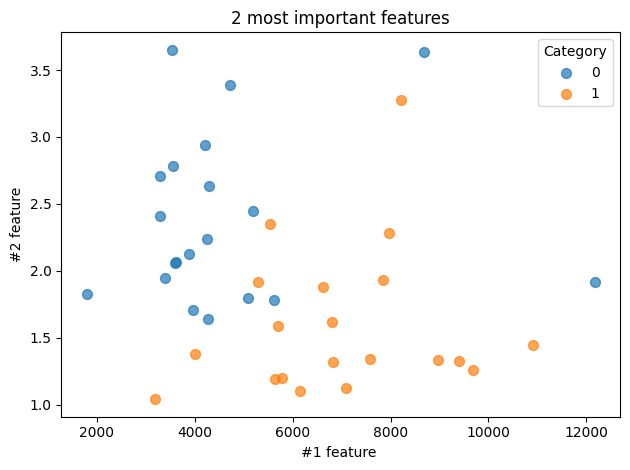

In [52]:
import matplotlib.pyplot as plt


df_binary = X_binary.copy()
# if y is a Series:
df_binary['category'] = y_binary
# if y is a single‐column DataFrame instead, use:
# df['category'] = y['category_column_name']

# --- Option A: matplotlib only ---
fig, ax = plt.subplots()
for cat, sub in df_binary.groupby('category'):
    ax.scatter(sub["ED_LV_vol"], sub['ED_RV_vol_div_ES_RV_vol'], label=cat, s=50, alpha=0.7)
ax.set_xlabel('#1 feature ')
ax.set_ylabel('#2 feature')
ax.set_title('2 most important features')
ax.legend(title='Category')
plt.tight_layout()
plt.show()

In [53]:
# Get the per‐class probabilities for every sample
proba = inf_pipeline.predict_proba(X)

threshold = 0.4
L = [0,0, 0,0]        # just three slots since you only ever check classes 1 and 2
I = []               # this will collect the ROW indices where both class‐1 and class‐2 prob > th

for row_idx, probs in enumerate(proba):
    # find which classes exceed the threshold among 1 and 2
    hits = [cls for cls in (1, 2) if probs[cls] > threshold]
    if len(hits) >= 2:
        print(f"Row {row_idx} probs:", probs)
        # increment your L counters
        for cls in hits:
            L[cls] += 1
        # append the ROW index, not the class index
        I.append(row_idx)

# Now I is a list of valid positions in X
print("Selected rows:", I)

# Subset X properly
X_sel = X.iloc[I]
# X_sel = X_sel_1.drop(columns=feature_importance[:5]["feature"].to_list())

# Compare old vs. new pipeline on exactly those rows
old_class = inf_pipeline.predict(X_sel)
new_prob  = inf_pipeline_binary.predict_proba(X_sel)
new_class =le.inverse_transform(inf_pipeline_binary.predict(X_sel))

print("\nOld probs:\n", inf_pipeline.predict_proba(X_sel))
print("New probs:\n", new_prob)

print("\nOld preds:\n", old_class)
print("New preds:\n", new_class)
print("True class:\n",y.loc[X.index[I], "Category"].values)
print("\nCounts per class (1 & 2):", L[1], L[2])



Row 61 probs: [0.         0.40036508 0.5864127  0.01322222 0.        ]
Row 79 probs: [0.         0.56877778 0.42455556 0.         0.00666667]
Row 91 probs: [0.         0.40704762 0.58739683 0.00555556 0.        ]
Selected rows: [61, 79, 91]

Old probs:
 [[0.         0.40036508 0.5864127  0.01322222 0.        ]
 [0.         0.56877778 0.42455556 0.         0.00666667]
 [0.         0.40704762 0.58739683 0.00555556 0.        ]]
New probs:
 [[0.66784036 0.3321596 ]
 [0.5116306  0.4883694 ]
 [0.4173805  0.5826195 ]]

Old preds:
 [2 1 2]
New preds:
 [1 1 2]
True class:
 [2 1 1]

Counts per class (1 & 2): 3 3


# REPREDICTING PREDICTION THAT HAVE LOW PROBABILITIES

In [26]:
import os
import numpy as np
import pandas as pd

# 1) --- Baseline submission (before binary adjustments) ---
y_pred_before = inf_pipeline.predict(X_test)

submission_before = pd.DataFrame({
    "Id":       X_test.index + 101,
    "Category": y_pred_before
})
submission_before.to_csv("submission_42_before.csv", index=False)
print("Saved baseline submission to submission_19_before.csv\n")

# 2) --- Find ambiguous rows in the test set ---
proba_test = inf_pipeline.predict_proba(X_test)
threshold = 0.35
I_test = [
    i for i, probs in enumerate(proba_test)
    if sum(probs[c] > threshold for c in (1, 2)) >= 2
]

if not I_test:
    print(f"No ambiguous rows found (both P(1) and P(2) > {treshold}).")
    new_preds = []
else:
    print("Ambiguous rows (both P(1)&P(2)>0.4):", I_test)
    # counters for how many times each class exceeds threshold
    L = {1: 0, 2: 0}
    for row_idx in I_test:
        probs = proba_test[row_idx]
        hits = [c for c in (1, 2) if probs[c] > threshold]
        print(f"Row {row_idx} probs: {probs}")
        for c in hits:
            L[c] += 1

    # old vs new on those rows
    X_sel    = X_test.iloc[I_test]
    # X_sel = X_sel_2.drop(columns=feature_importance[:5]["feature"].to_list())
    old_probs = inf_pipeline.predict_proba(X_sel)
    old_preds = inf_pipeline.predict(X_sel)
    new_probs = inf_pipeline_binary.predict_proba(X_sel)
    new_preds = le.inverse_transform(inf_pipeline_binary.predict(X_sel))

    print("\nOld probs:\n", old_probs)
    print("New probs:\n", new_probs)
    print("\nOld preds:\n", old_preds)
    print("New preds:\n", new_preds)
    print(f"\nCounts per class>thr (1 & 2): {L[1]}, {L[2]}\n")

# 3) --- Build and save the “after” submission ---
y_pred_after = y_pred_before.copy()
if I_test:
    for loc, new_lab in zip(I_test, new_preds):
        y_pred_after[loc] = new_lab

submission_after = pd.DataFrame({
    "Id":       X_test.index + 101,
    "Category": y_pred_after
})
submission_after.to_csv("submission_42_after.csv", index=False)
print("Saved updated submission to submission_42_after.csv")


Saved baseline submission to submission_19_before.csv

Ambiguous rows (both P(1)&P(2)>0.4): [11]
Row 11 probs: [0.         0.45777778 0.53666667 0.         0.00555556]

Old probs:
 [[0.         0.45777778 0.53666667 0.         0.00555556]]
New probs:
 [[0.52977682 0.47022318]]

Old preds:
 [2]
New preds:
 [2]

Counts per class>thr (1 & 2): 1, 1

Saved updated submission to submission_42_after.csv


In [17]:
import joblib
from datetime import datetime
import os

# Create a timestamp
currentDateTime = datetime.now()

# Get the base directory (current directory)
BASE_DIR = os.getcwd()
print(f"BASE_DIR: {BASE_DIR}")
RESULT_DIR = os.path.join(BASE_DIR,"output")
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)
    print(f"Directory created: {RESULT_DIR}")

# Create a folder named 'pipeline_<timestamp>' in the current directory
dir_name = name_folder
dir_path = os.path.join(RESULT_DIR, dir_name)

# If the directory doesn't exist, create it
if not os.path.exists(dir_path):
    os.mkdir(dir_path)
    print(f"Directory created: {dir_path}")

# Save the model inside this new folder
model_filename = 'pipeline_' + currentDateTime.strftime("%H-%M-%S") + '.pkl'
model_path = os.path.join(dir_path, model_filename)

# This is where you'd have your model defined
joblib.dump(grid_search, model_path)
print(f"Model saved to: {model_path}")


# Saving feature importance : 
feature_importance_filename ='pipeline_' + currentDateTime.strftime("%H-%M-%S") + '.csv' 
feature_importance_dir = os.path.join(dir_path,feature_importance_filename)
feature_importance.to_csv(feature_importance_dir)


# SAVING Description 
dict_filename = 'params.txt'
dict_path = os.path.join(dir_path, dict_filename)

with open(dict_path, 'w') as f:
    for key, val in informationDict.items():
        f.write(f"{key} : {val}\n")
print(f"Information about the model saved to: {dict_path}")


BASE_DIR: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction
Directory created: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/output/RF
Model saved to: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/output/RF/pipeline_22-15-24.pkl
Information about the model saved to: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/output/RF/params.txt
